### Installing necessary modules

In [ ]:
pip install nlopt

     |████████████████████████████████| 450kB 6.5MB/s 


###Importing necessary modules

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import autograd
import autograd.core
import autograd.extend
import autograd.numpy as anp
import functools
import numpy as np
import scipy
import scipy.ndimage
import scipy.sparse
import scipy.sparse.linalg
import nlopt
import matplotlib.pyplot as plt

### Caching Utilites

In [ ]:
class _WrappedArray:

  def __init__(self, value):
    self.value = value

  def __eq__(self, other):
    return np.array_equal(self.value, other.value)

  def __hash__(self):
    
    return hash(repr(self.value.ravel()))


def ndarray_safe_lru_cache(maxsize=128):
  def decorator(func):  
    @functools.lru_cache(maxsize)
    def cached_func(*args, **kwargs):
      args = tuple(a.value if isinstance(a, _WrappedArray) else a for a in args)
      kwargs = {k: v.value if isinstance(v, _WrappedArray) else v
                for k, v in kwargs.items()}
      return func(*args, **kwargs)

    @functools.wraps(func)
    def wrapper(*args, **kwargs): 
      args = tuple(_WrappedArray(a) if isinstance(a, np.ndarray) else a
                   for a in args)
      kwargs = {k: _WrappedArray(v) if isinstance(v, np.ndarray) else v
                for k, v in kwargs.items()}
      return cached_func(*args, **kwargs)

    return wrapper
  return decorator


### Autograd Utilities

In [ ]:
def _cone_filter_matrix(nelx, nely, radius, mask):
  x, y = np.meshgrid(np.arange(nelx), np.arange(nely), indexing='ij')

  rows = []
  cols = []
  values = []
  r_bound = int(np.ceil(radius))
  for dx in range(-r_bound, r_bound+1):
    for dy in range(-r_bound, r_bound+1):
      weight = np.maximum(0, radius - np.sqrt(dx**2 + dy**2))
      row = x + nelx * y
      column = x + dx + nelx * (y + dy)
      value = np.broadcast_to(weight, x.shape)

      val = (
          (mask > 0) &
          ((x+dx) >= 0) &
          ((x+dx) < nelx) &
          ((y+dy) >= 0) &
          ((y+dy) < nely)
      )
      rows.append(row[val])
      cols.append(column[val])
      values.append(value[val])

  data = np.concatenate(values)
  i = np.concatenate(rows)
  j = np.concatenate(cols)
  return scipy.sparse.coo_matrix((data, (i, j)), (nelx * nely,) * 2)


@ndarray_safe_lru_cache()
def normalized_cone_filter_matrix(nx, ny, radius, mask):
  """Calculate a sparse matrix appropriate for applying a cone filter."""
  raw_filters = _cone_filter_matrix(nx, ny, radius, mask).tocsr()
  weights = 1 / raw_filters.sum(axis=0).squeeze()
  diag_weights = scipy.sparse.spdiags(weights, 0, nx*ny, nx*ny)
  return (diag_weights @ raw_filters).tocsr()


@autograd.extend.primitive
def cone_filter(inputs, radius, mask=1, transpose=False):
  """Apply a cone filter of the given radius."""
  inputs = np.asarray(inputs)
  filters = normalized_cone_filter_matrix(
      *inputs.shape, radius=radius, mask=mask)
  if transpose:
    filters = filters.T
  outputs = filters @ inputs.ravel(order='F')
  return outputs.reshape(inputs.shape, order='F')


def _cone_filter_vjp(ans, inputs, radius, mask=1, transpose=False):
  return lambda g: cone_filter(g, radius, mask, transpose=not transpose)
autograd.extend.defvjp(cone_filter, _cone_filter_vjp)

In [ ]:
# This find_root function is basically used to enforce volume equality constraint.
# For making our optimization process free from any volumne constraint, we need not use this.
@autograd.primitive
def find_root(
    f, x, lower_bound, upper_bound, tolerance=1e-12, max_iterations=64):
  # Implicitly solve f(x,y)=0 for y(x) using binary search.
  # Assumption:  y is a scalar and f(x,y) is monotonic in y.
  for _ in range(max_iterations):
    y = 0.5 * (lower_bound + upper_bound)
    if upper_bound - lower_bound < tolerance:
      break
    if f(x, y) > 0:
      upper_bound = y
  return y

def grad_find_root(y, f, x, lower_bound, upper_bound, tolerance=None):
  def jvp(grad_y):
    g = lambda x: f(x, y)
    h = lambda y: f(x, y)
    return -autograd.grad(g)(x) / autograd.grad(h)(y) * grad_y
  return jvp

def _grad_undefined(_, *args):
  raise TypeError('gradient undefined for this input argument')


def _zero_grad(_, *args, **kwargs):
  def jvp(grad_ans):
    return 0.0 * grad_ans
  return jvp

autograd.extend.defvjp(
    find_root, _grad_undefined, grad_find_root,
    _zero_grad, _zero_grad, _zero_grad)

In [ ]:
@ndarray_safe_lru_cache(1)
def _get_solver(a_entries, a_indices, size, sym_pos):
  """Get a solver for applying the desired matrix factorization."""
  
  a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc() 
  #return a
  return scipy.sparse.linalg.splu(a).solve

def transpose_indices(indices):
    # returns the transposed indices for transpose sparse matrix creation
   return anp.flip(indices, axis=0)

## Sparse solver
@autograd.primitive
def solve_coo(a_entries,a_indices, b, sym_pos=False):
  """Solve a sparse system of linear equations.

  Args:
    a_entries: numpy array with shape (num_zeros,) giving values for non-zero
      matrix entries.
    a_indices: numpy array with shape (2, num_zeros) giving x and y indices for
      non-zero matrix entries.
    b: 1d numpy array specifying the right hand side of the equation.
    sym_pos: is the matrix guaranteed to be positive-definite?

  Returns:
    1d numpy array corresponding to the solution of a*x=b.
  """
  A = _get_solver(a_entries, a_indices, b.size, sym_pos)
  return A(b)


def solve_coo_adjoint(a_entries,  a_indices,  b, sym_pos=False):
  
  if sym_pos:
    return solve_coo(a_entries, a_indices, b, sym_pos)
  else:
    return solve_coo(a_entries,   a_indices[::-1], b, sym_pos)


def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
  def jvp(grad_ans):
    lambda_ = solve_coo_adjoint(a_entries,  a_indices, grad_ans, sym_pos)
    i, j = a_indices
    return -lambda_[i] * ans[j]
  return jvp

def grad_solve_coo_b(ans, a_entries, a_indices, b, sym_pos=False):
  def jvp(grad_ans):
    return solve_coo_adjoint(a_entries,  a_indices, grad_ans, sym_pos)
  return jvp


autograd.extend.defvjp(
    solve_coo, grad_solve_coo_entries,  _grad_undefined, grad_solve_coo_b)

In [ ]:
def compute_Q(U , xs, phi ,args):
  edof, penalS = args['edof'] , args['penalS']
  j0, jl, beta = args['j0'], args['jl'], args['beta']
  array = beta * anp.dot(U[edof],phi)
  actual = anp.exp(array) - 1
  je = jl*(xs**penalS) + j0 * (1/4) * anp.sum(actual,1)
  je_check = je < -jl
  args['je_check'] = je_check
  QQQQ = sp_mult(args['sup_val'], args['ind'] , args['ela']* 1/4 * je * ~je_check, 1)
  
  return QQQQ 


In [ ]:
def compute_djdu(U , phi ,args):
  edof = args['edof']
  j0, beta = args['j0'], args['beta']
  array = beta * anp.dot(U[edof],phi)
  three = j0 * beta* anp.exp(array) 
  djdu =  (1/4)* anp.dot(phi ,three.T)
  return (djdu * ~args['je_check']).ravel(order='F')



In [ ]:
@ndarray_safe_lru_cache(1)
def make_sparse(entries, indices, shape, flag=0):
    """Construct a sparse csr matrix
    Args:
      entries: numpy array with shape (M,) giving values for non-zero
        matrix entries.
      indices: numpy array with shape (2, M) giving x and y indices for
        non-zero matrix entries.
      shape: shape of resulting matrix
    Returns:
      sparse, complex, matrix with specified values
    """  
    if flag==0:
      coo = scipy.sparse.coo_matrix((entries, indices), shape=shape, dtype=anp.float64)
    else:
      coo = scipy.sparse.coo_matrix((entries, indices), dtype=anp.float64)
    return coo.tocsr()



@autograd.primitive
def sp_mult(entries, indices, x, flag = 0):
    """ Multiply a sparse matrix (A) by a dense vector (x)
    Args:
      entries: numpy array with shape (num_non_zeros,) giving values for non-zero
        matrix entries into A.
      indices: numpy array with shape (2, num_non_zeros) giving x and y indices for
        non-zero matrix entries into A.
      x: 1d numpy array specifying the vector to multiply by.
    Returns:
      1d numpy array corresponding to the result (b) of A * x = b.
    """
    N = x.size
    A = make_sparse(entries, indices, shape=(N, N), flag=flag)
    return A.dot(x)

def grad_sp_mult_entries_reverse(ans, entries, indices, x, flag=0):
    # x^T @ dA/de^T @ v => the outer product of x and v using the indices of A
    ia, ja = indices
    def vjp(v):
        return v[ia] * x[ja]
    return vjp

def grad_sp_mult_x_reverse(b, entries, indices, x, flag=0):
    # dx/de^T @ A^T @ v => multiplying A^T by v
    indices_T = transpose_indices(indices)
    def vjp(v):
        return sp_mult(entries, indices_T, v, flag)
    return vjp

autograd.extend.defvjp(sp_mult, grad_sp_mult_entries_reverse, _grad_undefined, grad_sp_mult_x_reverse)

In [ ]:
def scatter1d(nonzero_values, nonzero_indices, array_len):
  all_indices = anp.arange(array_len, dtype=anp.int64)
  zero_indices = anp.setdiff1d(all_indices, nonzero_indices, assume_unique=True)
  index_map = inverse_permutation(
      anp.concatenate([nonzero_indices, zero_indices]))
  u_values = anp.concatenate([nonzero_values, anp.zeros(len(zero_indices))])
  return u_values[index_map]

In [ ]:
def inverse_permutation(indices):
  inverse_perm = anp.zeros(len(indices), dtype=anp.int64)
  inverse_perm[indices] = anp.arange(len(indices), dtype=anp.int64)
  return inverse_perm

### Physics , Topology utilities

In [ ]:
def physical_density(x, args, volume_contraint=False, cf=True):
  shape = (args['nely'], args['nelx'])
  assert x.shape == shape or x.ndim == 1
  x = x.reshape(shape)
  if volume_contraint:
    mask = anp.broadcast_to(args['mask'], x.shape) > 0
    x_designed = sigmoid_with_constrained_mean(x[mask], args['volfrac'])
    x_flat = scatter1d(
        x_designed, anp.flatnonzero(mask), x.size)
    x = x_flat.reshape(x.shape)
  else:
    x = x * args['mask']
  if cf:
    x = cone_filter(x, args['filter_width'], args['mask'])
  return x

def mean_density(x, args, volume_contraint=False, cf=True):
  
  auxil = physical_density(x, args, volume_contraint, cf=True)
  return (auxil.mean()
          / anp.mean(args['mask']))

In [ ]:
def get_stiffness_matrix():   ### This is called Conductivity matrix in case of thermal 
  g = anp.array([2/3 , -1/6 , -1/3, -1/6])           ### and electrical problems
  return anp.array([
                   [g[0] , g[1], g[2], g[3]],
                   [g[3] , g[0], g[1], g[2]],
                   [g[2] , g[3], g[0], g[1]],
                   [g[1] , g[2], g[3], g[0]]
                   ])

In [ ]:
@autograd.primitive
def mysub(U, delt):
  pp = U - delt
  return pp 
def mysub_grad_U(ans, U, delt):
  def vjp(v):
    return v
  return vjp 

def mysub_grad_delt(ans, U, delt):
  def vjp(v):
    return -v 
  return vjp

autograd.extend.defvjp(mysub , mysub_grad_U , mysub_grad_delt)

In [ ]:
@ndarray_safe_lru_cache(1)
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
  index_map = inverse_permutation(
      anp.concatenate([freedofs, fixdofs]))
  keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
  i = index_map[k_ylist[keep]]
  j = index_map[k_xlist[keep]]
  i_all = k_ylist
  j_all = k_xlist
  return index_map, keep, anp.stack([i, j]) , anp.stack([i_all, j_all])

def get_sol(x_phys, ke, Q, args):
  stiffness = young_modulus(x_phys, args['young'], args['young_min'], p=3)
  k_entries, k_ylist, k_xlist = get_k(stiffness, ke, args)
  edof = args['edof']
  freedofs = args['freedofs']
  fixdofs  = args['fixdofs']
  penalS = args['penalS']
  phi = compute_shape()
  jl,j0 = args['jl'] , args['j0']
  beta = args['beta']
  index_map, keep, indices, indices_all = _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist)
  iteration = 0 
  xs = 1-x_phys
  xs = xs.ravel(order='F')
  nely, nelx = x_phys.shape
  U = anp.zeros((nelx+1, nely+1)).ravel()
  U[fixdofs] = args['Vbus']
  Sumit = U
  ela = args['ela']
  nrtol = (nelx*nely)* 1e-10
  
  while iteration <=20:     #### Newton Raphson   --- No. of iterations can be increased further
    iteration+=1
    
    R_ = anp.subtract(sp_mult(k_entries ,indices_all, Sumit) , Q)  
    
    if (anp.linalg.norm(R_[freedofs])/ (anp.linalg.norm(Q))) < nrtol/100:
      break
    
    djdu = compute_djdu(Sumit, phi, args) 
    
    AUX = ((1/4)*ela*anp.ones((4,1))* djdu).ravel(order='F')
    K_aux = anp.subtract(k_entries , AUX)
    deltaU = solve_coo(K_aux[keep], indices, R_[freedofs], sym_pos=True)
    u_values = anp.concatenate([mysub(Sumit[freedofs] , deltaU), anp.ones(len(fixdofs))*args['Vbus']])
    Q  = compute_Q(u_values[index_map] ,  xs,  phi, args)
    Sumit = u_values[index_map]

  ret_Q = compute_Q(Sumit ,  xs,  phi, args)
  return ret_Q
  

def get_k(stiffness, ke, args):
  nely, nelx = stiffness.shape
  edof = args['edof']
  x_list = anp.repeat(edof, 4)  
  y_list = anp.tile(edof, 4).flatten()  

  # make the stiffness matrix
  kd = stiffness.ravel(order='F').T.reshape(1,-1) 
  value_list = ke.ravel(order='F').reshape(-1,1) * kd
  
  value_list = value_list.ravel(order='F')
  return value_list, y_list, x_list


def young_modulus(x, e_0, e_min, p=3):
  return e_min + x ** p * (e_0 - e_min)

In [ ]:
def sigmoid(x):
  return anp.tanh(0.5*x)*.5 + 0.5


def logit(p):
  p = anp.clip(p, 0.001, 1)
  return anp.log(p) - anp.log1p(-p- 10e-12)


def sigmoid_with_constrained_mean(x, average):   ### The commented lines of code are used to impose
  #f = lambda x, y: sigmoid(x + y).mean() - average            volume constraint
  #lower_bound = logit(average) - anp.max(x)
  #upper_bound = logit(average) - anp.min(x)
  #b = find_root(f, x, lower_bound, upper_bound)
  return sigmoid(x)     ## If no volume constraint is required, this should be left commented


def compute_shape():
  Xa = anp.array([0.211324865405187, 0.788675134594813, 0.788675134594813, 0.211324865405187])
  Yb = anp.array([0.211324865405187, 0.211324865405187, 0.788675134594813 ,0.788675134594813])

  phi1 = anp.multiply(1-Xa,Yb)
  phi2 = anp.multiply(1-Xa,1-Yb)
  phi3 = anp.multiply(Xa, Yb)
  phi4 = anp.multiply(Xa, 1-Yb) 

  phi = anp.array([phi1, phi3 , phi4 , phi2])

  return phi



def cal_force(x_phys, args):    
  penalS = args['penalS']
  nely, nelx = x_phys.shape
  edof = args['edof']
  xs = 1 - x_phys 
  xs = xs.ravel(order='F')
  phi = compute_shape()
  jl , j0 = args['jl'], args['j0']
  beta = args['beta']
  U = anp.zeros((nelx+1, nely+1)).ravel()
  U[args['fixdofs']] = args['Vbus']
  Q  = compute_Q(U, xs, phi, args) 
  return Q 

def objective(x,ke, args, volume_contraint=False, cfo=True):
  
  x_phys = physical_density(x, args, volume_contraint=volume_contraint,cf=cfo)
  Q= cal_force(x_phys , args)
  Q = get_sol(x_phys , ke , Q, args)
  power = args['Vbus'] * sum(Q)
  return -power

def objective2(x,ke, args, volume_contraint=False, cfo=True):  ## Without any filtering
  x_phys = x
  Q= cal_force(x_phys , args)
  Q = get_sol(x_phys , ke , Q, args)
  power = args['Vbus'] * sum(Q)
  return -power


### Models

In [ ]:
layers = tf.keras.layers

In [ ]:
def batched_topo_loss(params, envs):
  losses = [env.objective(params[i], volume_contraint=True)
            for i, env in enumerate(envs)]
  return anp.stack(losses)

In [ ]:
def convert_autograd_to_tensorflow(func):
  @tf.custom_gradient
  def wrapper(x):
    vjp, ans = autograd.core.make_vjp(func, x.numpy())
    return ans, vjp
  return wrapper

In [ ]:
def set_random_seed(seed):
  if seed is not None:
    anp.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
class Model(tf.keras.Model):

  def __init__(self, seed=None, args=None):
    super().__init__()
    set_random_seed(seed)
    self.seed = seed
    self.env = Environment(args)

  def loss(self, logits):
    logits = 0.0 + tf.cast(logits, tf.float64)
    f = lambda x: batched_topo_loss(x, [self.env])
    losses = convert_autograd_to_tensorflow(f)(logits)
    ret = tf.reduce_mean(losses)
    return ret

In [ ]:
class PixelModel(Model):

  def __init__(self, seed=None, args=None):
    super().__init__(seed, args)
    shape = (1, self.env.args['nely'], self.env.args['nelx'])
    z_init = anp.ones(shape) * args['volfrac']
    self.z = tf.Variable(z_init, trainable=True)

  def call(self, inputs=None):
    return self.z

In [ ]:
def global_normalization(inputs, epsilon=1e-6):
  mean, variance = tf.nn.moments(inputs, axes=list(range(len(inputs.shape))))
  net = inputs
  net -= mean
  net *= tf.math.rsqrt(variance + epsilon)
  return net

In [ ]:
def UpSampling2D(factor):
  return layers.UpSampling2D((factor, factor), interpolation='bilinear')


def Conv2D(filters, kernel_size, **kwargs):
  return layers.Conv2D(filters, kernel_size, padding='same', **kwargs)


class AddOffset(layers.Layer):

  def __init__(self, scale=1):
    super().__init__()
    self.scale = scale

  def build(self, input_shape):  
    self.bias = self.add_weight(
        shape=input_shape, initializer=tf.initializers.GlorotNormal, trainable=True, name='bias')

  def call(self, inputs):
    return inputs + self.scale * self.bias

In [ ]:
class CNNModel(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size=128,
      dense_channels=32,
      resizes=(1, 1, 2, 2, 1),
      conv_filters=(128, 64, 32, 16, 1),
      offset_scale=10,
      kernel_size=(5, 5),
      latent_scale=1.0,
      activation=tf.nn.leaky_relu,   
      conv_initializer=tf.initializers.GlorotNormal,
      normalization=global_normalization,
  ):
    super().__init__(seed, args)

    activation = layers.Activation(activation)

    total_resize = int(anp.prod(resizes))
    h = self.env.args['nely'] // total_resize
    w = self.env.args['nelx'] // total_resize

    net = inputs = layers.Input((latent_size,), batch_size=1)
    filters = h * w * dense_channels
    net = layers.Dense(filters, kernel_initializer=conv_initializer)(net)
    net = layers.Reshape([h, w, dense_channels])(net)

    for resize, filters in zip(resizes, conv_filters):
      net = activation(net)
      net = UpSampling2D(resize)(net)
      net = normalization(net)
      net = Conv2D(
          filters, kernel_size, kernel_initializer=conv_initializer)(net)
      if offset_scale != 0:
        net = AddOffset(offset_scale)(net)

    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    self.z = self.add_weight(
        shape=inputs.shape, initializer=conv_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

### A few Vbus Configurations

In [ ]:
from typing import Optional, Union
import dataclasses

@dataclasses.dataclass
class Problem:
  """Description of a topology optimization problem.

  Attributes:
    normals: float64 array of shape (width+1, height+1) where a value of 1
      indicates a "fixed" coordinate, and 0 indicates free coordinate. The fixed coordinates have
      Vbus.
    density: fraction of the design region that should be non-zero.
    mask: scalar or float64 array of shape (height, width) that is multiplied by
      the design mask before and after applying the blurring filters. Values of
      1 indicate regions where the material can be optimized; values of 0 are
      constrained to be empty. For a simple case, mask is 1.
    name: optional name of this problem.
    width:  width of the domain.
    height: height of the domain.
  """
  normals: np.ndarray
  density: float
  mask: Union[np.ndarray, float] = 1
  name: Optional[str] = None
  width: int = dataclasses.field(init=False)
  height: int = dataclasses.field(init=False)

  def __post_init__(self):
    self.width = self.normals.shape[0] - 1
    self.height = self.normals.shape[1] - 1

    if self.normals.shape != (self.width + 1, self.height + 1):
      raise ValueError(f'normals has wrong shape: {self.normals.shape}')
    """if self.forces.shape != (self.width + 1, self.height + 1, 1):
      raise ValueError(f'forces has wrong shape: {self.forces.shape}')"""
    if (isinstance(self.mask, np.ndarray)
        and self.mask.shape != (self.height, self.width)):
      raise ValueError(f'mask has wrong shape: {self.mask.shape}')



def Problem1(width=40, height=40, density=0.4):   ### Left Edge complete Vbus
  normals = np.zeros((width + 1, height + 1))
  normals[:, 0] = 1

  return Problem(normals,density)

def Problem2(width=40, height=40, density=0.4):  ### All 4 corners have Vbus
  normals = np.zeros((width+1, height+1))
  normals[0,0] = 1
  normals[0,-1] =1
  normals[-1,0] =1
  normals[-1,-1] = 1

  return Problem(normals, density)

def Problem3(width=40, height=40, density=0.4):   ### Center Point has Vbus
  normals = np.zeros((width+1, height+1))
  normals[(width+1)//2 , (height+1)//2] = 1

  return Problem(normals, density)

def Problem4(width=40, height=40, density=0.4):  ### A fraction of the left edge is Vbus
  normals = np.zeros((width+1, height+1))
  normals[(width+1)//2 - 50: (width+1)//2 + 50,  0] = 1

  return Problem(normals, density)


### Argument Environment for re-usability of code 

In [ ]:
def specified_task(problem):
  """Given a configuration of Vbus, return parameters for running a topology optimization."""
  fixdofs = anp.flatnonzero(problem.normals.ravel(order='F'))
  alldofs = anp.arange((problem.width + 1) * (problem.height + 1))
  freedofs = anp.sort(list(set(alldofs) - set(fixdofs)))

  ely, elx = anp.meshgrid(range(problem.height), range(problem.width)) 
  n1 = (problem.height+1)*(elx+0) + (ely+0)
  n2 = (problem.height+1)*(elx+1) + (ely+0)
  edof = anp.array([n1, n2, n2+1, n1+1])
  edof = edof.T
  aux = []
  for i in range(edof.shape[1]):
    auxa = []
    for j in range(edof.shape[0]):
      auxa.append(list(edof[j][i][::-1]))
    aux.append(anp.array(auxa))
  edof = anp.concatenate(aux)
  val_ = []
  i_l, j_l = [],[]
  for i in range(edof.shape[0]):
    for j in range(edof.shape[1]):
      val_.append(1)
      i_l.append(edof[i][j])
      j_l.append(i)
  
  params = {
      # material properties
      'young': 100,  ## represents thermal/electrical Young's modulus , known as Conductivity
      'young_min': 0.02,  ## represent minimum Conductivity
      # constraints
      'volfrac': problem.density,  ## Used only if volume constraint is enforced.
      'xmin': 0.001,
      'xmax': 1.0,
      # input parameters
      'jl': 310,
      'j0': -0.006,
      'beta': 16.4,
      'nelx': problem.width,
      'nely': problem.height,
      'ela': ((1.5 * 1e-2) / problem.width)**2,    ## Area of each element in the grid in sq. m
      'mask': problem.mask,
      'freedofs': freedofs,
      'fixdofs': fixdofs,
      'penalS': 3.0,   ## Penalty for shading
      'penal':3.0,     
      'filter_width': 1.5,
      'Vbus': 0.50,
      'edof' : edof , 
      'je_check': anp.array([0]),
      'sup_val' : anp.array(val_),
      'ind' :  anp.stack([anp.array(i_l), anp.array(j_l)]) ## sup_val and ind form a sparse matrix
  }
  return params

In [ ]:
class Environment:

  def __init__(self, args):
    self.args = args
    self.ke = get_stiffness_matrix()  ## Stiffness matrix, in case of heat and electrical
                                      ## problems, it is called element Conductivity matrix

  def reshape(self, params):
    return params.reshape(self.args['nely'], self.args['nelx'])

  def render(self, params, volume_contraint=True):
    return physical_density(
        self.reshape(params), self.args, volume_contraint=volume_contraint,
    )

  def objective(self, params, volume_contraint=False):  ## With filtering
    return objective(
        self.reshape(params), self.ke, self.args,
        volume_contraint=volume_contraint,
    )

  def objective2(self, params, volume_contraint=False):  ## Without filtering
    return objective(
        self.reshape(params), self.ke, self.args,
        volume_contraint=volume_contraint,
    )

  def constraint(self, params):
    volume = mean_density(self.reshape(params), self.args)
    return volume - self.args['volfrac']

### Training Utilities for MMA and CNN-LBFGS

In [ ]:
import scipy.optimize
import xarray
from absl import logging

In [ ]:
def _set_variables(variables, x):
  shapes = [v.shape.as_list() for v in variables]
  values = tf.split(x, [anp.prod(s) for s in shapes])
  for var, value in zip(variables, values):
    var.assign(tf.reshape(tf.cast(value, var.dtype), var.shape))

In [ ]:
def _get_variables(variables):
  return anp.concatenate([
      v.numpy().ravel() if not isinstance(v, anp.ndarray) else v.ravel()
      for v in variables])

In [ ]:
def optimizer_result_dataset(losses, frames, save_intermediate_designs=False):
  best_design = anp.nanargmin(losses) 
  logging.info(f'Final loss: {losses[best_design]}')
  if save_intermediate_designs:
    ds = xarray.Dataset({
        'loss': (('step',), losses),
        'design': (('step', 'y', 'x'), frames),
    }, coords={'step': anp.arange(len(losses))})
  else:
    ds = xarray.Dataset({
        'loss': (('step',), losses),
        'design': (('y', 'x'), frames[best_design]),
    }, coords={'step': anp.arange(len(losses))})
  return ds

In [ ]:
def train_lbfgs(
    model, max_iterations, save_intermediate_designs=True, **kwargs):
  model(None) 

  losses = []
  frames = []

  tvars = model.trainable_variables

  def value_and_grad(x):
    _set_variables(tvars, x)
    with tf.GradientTape() as t:
      t.watch(tvars)
      logits = model(None)
      loss = model.loss(logits)
    
    print("Loss", loss, " ", "Eff", -loss/2.25 * 1000)
    
    grads = t.gradient(loss, tvars)
    frames.append(logits.numpy().copy())
    losses.append(loss.numpy().copy())

    return float(loss.numpy()), _get_variables(grads).astype(anp.float64)

  x0 = _get_variables(tvars).astype(anp.float64)
  
  _, _, info = scipy.optimize.fmin_l_bfgs_b(
      value_and_grad, x0, maxfun=max_iterations, factr=1, pgtol=1e-14, **kwargs
  )
  logging.info(info)

  designs = [model.env.render(x, volume_contraint=True) for x in frames]
  return optimizer_result_dataset(
      anp.array(losses), anp.array(designs), save_intermediate_designs)

In [ ]:
def method_of_moving_asymptotes(
    model, max_iterations, save_intermediate_designs=True):

  if not isinstance(model, PixelModel):
    raise ValueError('MMA only defined for pixel models')

  env = model.env
  grad = []
  x0 = _get_variables(model.trainable_variables).astype(np.float64)

  def objective(x):
    return env.objective(x, volume_contraint=False)

  def constraint(x):
    return env.constraint(x)

  def wrap_autograd_func(func, losses=None, frames=None):
    def wrapper(x, grad):
      if grad.size > 0:
        value, grad[:] = autograd.value_and_grad(func)(x)
      else:
        value = func(x)
      if losses is not None:
        losses.append(value)
        print("Loss ", value , "  Eff " , -value / 2.25 * 1000)
      if frames is not None:
        frames.append(env.reshape(x).copy())
      return value
    return wrapper

  losses = []
  frames = []
  
  opt = nlopt.opt(nlopt.LD_MMA, x0.size)
  opt.set_lower_bounds(0)
  opt.set_upper_bounds(1.0)
  opt.set_min_objective(wrap_autograd_func(objective, losses, frames))
  opt.add_inequality_constraint(wrap_autograd_func(constraint), 1e-8)
  opt.set_maxeval(max_iterations + 1)
  opt.optimize(x0)

  designs = [env.render(x, volume_contraint=False) for x in frames]
  return optimizer_result_dataset(np.array(losses), np.array(designs),
                                  save_intermediate_designs)

###Plotting utilities

In [ ]:
def all_plot(dsc, dsm, limit=100):
  fig ,ax = plt.subplots(1,2, figsize=(9,9))

  ax[0].imshow(dsc.design[-1] , cmap='Greys')
  ax[0].set_title("CNN-LBFGS")

  ax[1].imshow(dsm.design[-1], cmap='Greys')
  ax[1].set_title("MMA")


In [ ]:
def all_plot2(dsc, dsm,  name, limit=0):  ## Plotting the efficiency values
  fig ,ax = plt.subplots(1,1, figsize=(5,5))

  ax.plot(-dsc.loss.values[limit:]/2.25 * 1000, label="CNN-LBFGS")
  ax.plot(-dsm.loss.values[limit:]/2.25 * 1000, label="MMA")

  ax.legend()
  ax.set(xlabel="Optimization Step", ylabel="Loss")

  fig.savefig(name, format='eps')

In [ ]:
def all_plot3(dsc, dsm,  name, limit=0):  ## Plotting the grayness values
  fig ,ax = plt.subplots(1,1, figsize=(5,5))

  gc = []
  gm = []
  for p in dsc.design:
    x = 4 * p*(1-p)
    gc.append(x.mean())
  
  for p in dsm.design:
    x = 4 * p*(1-p)
    gm.append(x.mean())

  ax.plot(gc[limit:], label="CNN-LBFGS")
  ax.plot(gm[limit:], label="MMA")

  ax.legend()
  ax.set(xlabel="Optimization Step", ylabel="Grayness")

  fig.savefig(name, format='eps')

### Implicit Volume Fraction

No volume fraction is passed as argument, and the models are allowed to find an optimal volume fraction

#### Prob 1

In [ ]:
pr = Problem1(200,200)
args = specified_task(pr)

In [ ]:
envv = Environment(args)

In [ ]:
cnn = CNNModel(args = args)

In [ ]:
mma = PixelModel(args=args)

In [ ]:
ds_mma = method_of_moving_asymptotes(mma ,100)

LOSS  -0.010670958985434348   Eff  4.742648437970821
LOSS  -0.010671100968999647   Eff  4.742711541777621
LOSS  -0.010672529588466158   Eff  4.743346483762737
LOSS  -0.01069301859531423   Eff  4.752452709028547
LOSS  -0.010978928584879711   Eff  4.879523815502094
LOSS  -0.013216230288873069   Eff  5.873880128388031
LOSS  -0.01415024496821039   Eff  6.2889977636490615
LOSS  -0.01521488078273899   Eff  6.762169236772884
LOSS  -0.015424784960741435   Eff  6.855459982551749
LOSS  -0.01487659219963778   Eff  6.611818755394569
LOSS  -0.015531550577399758   Eff  6.902911367733226
LOSS  -0.01547370225732839   Eff  6.8772010032570625
LOSS  -0.015573469728925045   Eff  6.921542101744465
LOSS  -0.015514798204402493   Eff  6.89546586862333
LOSS  -0.015603123014759579   Eff  6.934721339893146
LOSS  -0.015629572025458473   Eff  6.9464764557593215
LOSS  -0.015775677257209565   Eff  7.011412114315362
LOSS  -0.016047978040932605   Eff  7.132434684858936
LOSS  -0.016622218867479374   Eff  7.387652829990

In [ ]:
ds_cnn = train_lbfgs(cnn,200)

Loss tf.Tensor(-0.004367894402744081, shape=(), dtype=float64)   Eff tf.Tensor(1.9412864012195916, shape=(), dtype=float64)
Loss tf.Tensor(-0.010770296982529643, shape=(), dtype=float64)   Eff tf.Tensor(4.786798658902063, shape=(), dtype=float64)
Loss tf.Tensor(0.0006522662035908094, shape=(), dtype=float64)   Eff tf.Tensor(-0.2898960904848042, shape=(), dtype=float64)
Loss tf.Tensor(-0.016397257976491556, shape=(), dtype=float64)   Eff tf.Tensor(7.287670211774025, shape=(), dtype=float64)
Loss tf.Tensor(0.0018218650658376474, shape=(), dtype=float64)   Eff tf.Tensor(-0.8097178070389544, shape=(), dtype=float64)
Loss tf.Tensor(-0.017682657139219383, shape=(), dtype=float64)   Eff tf.Tensor(7.858958728541948, shape=(), dtype=float64)
Loss tf.Tensor(-0.018686708386558008, shape=(), dtype=float64)   Eff tf.Tensor(8.305203727359114, shape=(), dtype=float64)
Loss tf.Tensor(-0.02031196421020649, shape=(), dtype=float64)   Eff tf.Tensor(9.027539648980662, shape=(), dtype=float64)
Loss tf.Tens

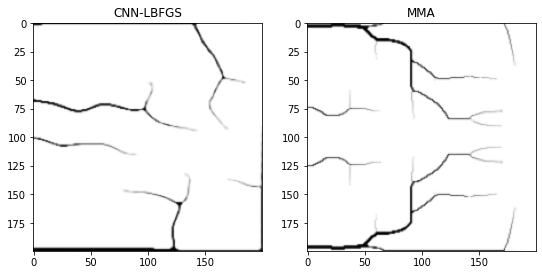

In [ ]:
all_plot(ds_cnn, ds_mma , 0)

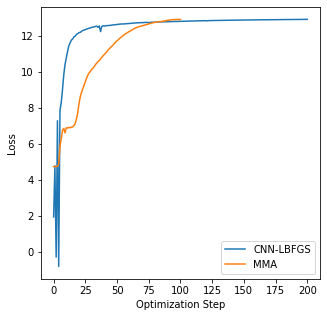

In [ ]:
all_plot2(ds_cnn, ds_mma , "pr1_loss.eps")

In [ ]:
ds_mma.design[-1].min() ,  ds_mma.design[-1].max()

(<xarray.DataArray 'design' ()>
 array(0.)
 Coordinates:
     step     int64 100, <xarray.DataArray 'design' ()>
 array(1.)
 Coordinates:
     step     int64 100)

In [ ]:
-envv.objective2(ds_cnn.design[-1].values) / 2.25 * 1000

12.921747271972796

In [ ]:
-envv.objective2(ds_mma.design[-1].values) / 2.25 * 1000

12.914536501906557

In [ ]:
ds_cnn.design[-1].mean()

<xarray.DataArray 'design' ()>
array(0.03882268)
Coordinates:
    step     int64 200

In [ ]:
cnn_aux = np.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_cnn.design[-1].values[i][j] > 0.03882:
      cnn_aux[i][j] = 1

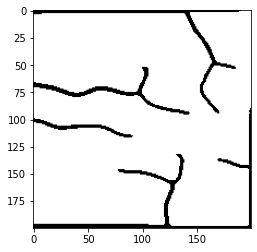

In [ ]:
plt.imshow(cnn_aux, cmap='Greys')

In [ ]:
ds_mma.design[-1].mean()

<xarray.DataArray 'design' ()>
array(0.03946811)
Coordinates:
    step     int64 100

In [ ]:
mma_aux = np.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_mma.design[-1].values[i][j] > 0.03947:
      mma_aux[i][j] = 1

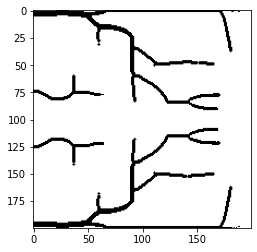

In [ ]:
plt.imshow(mma_aux, cmap='Greys')

In [ ]:
-envv.objective2(cnn_aux)/2.25 * 1000

12.715319428133022

In [ ]:
-envv.objective2(mma_aux)/2.25 * 1000

12.624560134744572

#### Prob 2

In [ ]:
pr = Problem2(200,200)
args = specified_task(pr)

In [ ]:
cnn = CNNModel(args = args)

In [ ]:
mma = PixelModel(args=args)

In [ ]:
ds_mma2 = method_of_moving_asymptotes(mma, 150)

Loss  -0.005013583837884764   Eff  2.2282594835043392
Loss  -0.005013593331871382   Eff  2.2282637030539476
Loss  -0.005013688266873857   Eff  2.228305896388381
Loss  -0.0050150544432141534   Eff  2.228913085872957
Loss  -0.005034572622535361   Eff  2.2375878322379386
Loss  -0.005302143418720442   Eff  2.356508186097974
Loss  -0.00904183065587993   Eff  4.0185914026133025
Loss  -0.017251051242772222   Eff  7.667133885676543
Loss  -0.014583963932821105   Eff  6.481761747920491
Loss  -0.02049466903629615   Eff  9.1087417939094
Loss  -0.020564556949208838   Eff  9.139803088537262
Loss  -0.021202399812528732   Eff  9.423288805568326
Loss  -0.021614080100745708   Eff  9.606257822553648
Loss  -0.02212446704983153   Eff  9.83309646659179
Loss  -0.02239154956369951   Eff  9.951799806088673
Loss  -0.022918298116564196   Eff  10.185910274028531
Loss  -0.024095853723456368   Eff  10.709268321536163
Loss  -0.024998267912484638   Eff  11.110341294437616
Loss  -0.025499080048480935   Eff  11.3329244

In [ ]:
ds_cnn2 = train_lbfgs(cnn, 200)

Loss tf.Tensor(-0.004351522132139769, shape=(), dtype=float64)   Eff tf.Tensor(1.9340098365065639, shape=(), dtype=float64)
Loss tf.Tensor(-0.014155886236637803, shape=(), dtype=float64)   Eff tf.Tensor(6.2915049940612455, shape=(), dtype=float64)
Loss tf.Tensor(-0.002368489066436746, shape=(), dtype=float64)   Eff tf.Tensor(1.0526618073052203, shape=(), dtype=float64)
Loss tf.Tensor(-0.02117074719894633, shape=(), dtype=float64)   Eff tf.Tensor(9.409220977309479, shape=(), dtype=float64)
Loss tf.Tensor(-0.02268622769504441, shape=(), dtype=float64)   Eff tf.Tensor(10.082767864464182, shape=(), dtype=float64)
Loss tf.Tensor(-0.023183263605074052, shape=(), dtype=float64)   Eff tf.Tensor(10.303672713366247, shape=(), dtype=float64)
Loss tf.Tensor(-0.024281898808558747, shape=(), dtype=float64)   Eff tf.Tensor(10.79195502602611, shape=(), dtype=float64)
Loss tf.Tensor(-0.02508102408666139, shape=(), dtype=float64)   Eff tf.Tensor(11.147121816293952, shape=(), dtype=float64)
Loss tf.Tenso

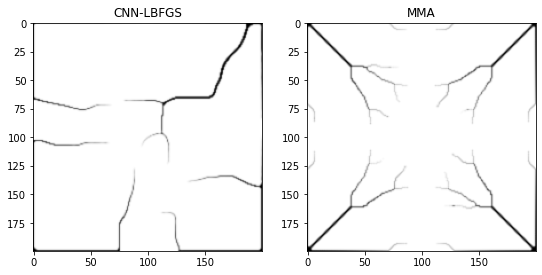

In [ ]:
all_plot(ds_cnn2, ds_mma2 , 0)

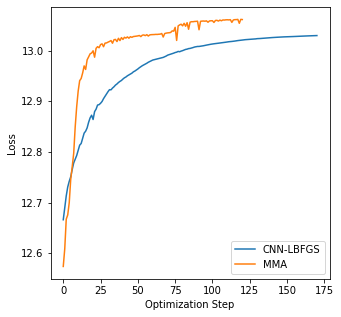

In [ ]:
all_plot2(ds_cnn2, ds_mma2, "pr2loss.eps", 30)

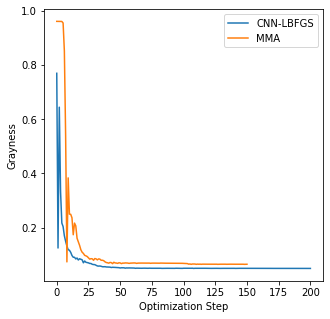

In [ ]:
all_plot3(ds_cnn2, ds_mma2,"pr2gray.eps")

In [ ]:
envv = Environment(args)

In [ ]:
-envv.objective2(ds_cnn2.design[-1].values) / 2.25 * 1000

12.78389679781122

In [ ]:
-envv.objective2(ds_mma2.design[-1].values) / 2.25 * 1000

12.838362431182277

In [ ]:
cnn_aux1 = anp.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_cnn2.design[-1][i][j] >= 0.02:
      cnn_aux1[i][j] = 1

In [ ]:
mma_aux1 = anp.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_mma2.design[-1][i][j] >= 0.02:
      mma_aux1[i][j] = 1

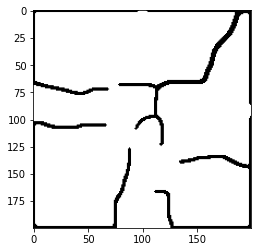

In [ ]:
plt.imshow(cnn_aux1, cmap='Greys')

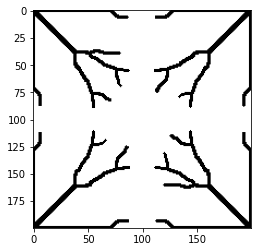

In [ ]:
plt.imshow(mma_aux1, cmap='Greys')

In [ ]:
-envv.objective2(cnn_aux1) / 2.25 * 1000

12.471994034627938

In [ ]:
-envv.objective2(mma_aux1) / 2.25 * 1000

12.054108924529102

In [ ]:
ds_cnn2.design[-1].mean() , ds_mma2.design[-1].mean()

(<xarray.DataArray 'design' ()>
 array(0.03078328)
 Coordinates:
     step     int64 200, <xarray.DataArray 'design' ()>
 array(0.03529892)
 Coordinates:
     step     int64 150)

In [ ]:
cnn_aux2 = anp.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_cnn2.design[-1][i][j] >= 0.03078328:
      cnn_aux2[i][j] = 1

In [ ]:
mma_aux2 = anp.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_mma2.design[-1][i][j] >= 0.03529892:
      mma_aux2[i][j] = 1

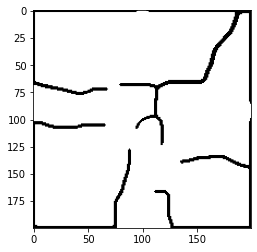

In [ ]:
plt.imshow(cnn_aux2, cmap='Greys')

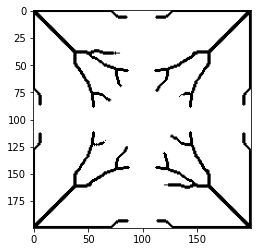

In [ ]:
plt.imshow(mma_aux2, cmap='Greys')

In [ ]:
-envv.objective2(cnn_aux2) / 2.25 * 1000

12.516923926779313

In [ ]:
-envv.objective2(mma_aux2) / 2.25 * 1000

12.241439742005573

#### Prob 3

In [ ]:
pr = Problem3(200,200)
args = specified_task(pr)

In [ ]:
cnn = CNNModel(args=args)
mma = PixelModel(args=args)

In [ ]:
ds_mma = method_of_moving_asymptotes(mma, 100)

Loss  -0.005013583837884406   Eff  2.2282594835041807
Loss  -0.00501359349297621   Eff  2.2282637746560936
Loss  -0.0050136900371167544   Eff  2.228306683163002
Loss  -0.005015079034356917   Eff  2.228924015269741
Loss  -0.005034867044685252   Eff  2.2377186865267786
Loss  -0.005302991144834817   Eff  2.3568849532599185
Loss  -0.009042567291174022   Eff  4.018918796077343
Loss  -0.017251774528951165   Eff  7.667455346200518
Loss  -0.014580167126676178   Eff  6.480074278522745
Loss  -0.020494281551338336   Eff  9.108569578372594
Loss  -0.02055401018845963   Eff  9.13511563931539
Loss  -0.021165955919610336   Eff  9.407091519826816
Loss  -0.021546051937569862   Eff  9.576023083364383
Loss  -0.021721293193881924   Eff  9.653908086169745
Loss  -0.021957885624571436   Eff  9.759060277587306
Loss  -0.022408599549633732   Eff  9.959377577614992
Loss  -0.023380372762711845   Eff  10.391276783427488
Loss  -0.024355917149239886   Eff  10.824852066328837
Loss  -0.02490170941653756   Eff  11.06742

In [ ]:
ds_cnn = train_lbfgs(cnn,200)

Loss tf.Tensor(-0.004363802265337352, shape=(), dtype=float64)   Eff tf.Tensor(1.9394676734832674, shape=(), dtype=float64)


/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return f_raw(*args, **kwargs)


Loss tf.Tensor(-2.852105686275098e-07, shape=(), dtype=float64)   Eff tf.Tensor(0.00012676025272333769, shape=(), dtype=float64)
Loss tf.Tensor(-0.009764799384937186, shape=(), dtype=float64)   Eff tf.Tensor(4.33991083774986, shape=(), dtype=float64)
Loss tf.Tensor(-0.012642945100873888, shape=(), dtype=float64)   Eff tf.Tensor(5.619086711499506, shape=(), dtype=float64)
Loss tf.Tensor(-0.01720511691308412, shape=(), dtype=float64)   Eff tf.Tensor(7.646718628037387, shape=(), dtype=float64)
Loss tf.Tensor(-0.017641078693889985, shape=(), dtype=float64)   Eff tf.Tensor(7.84047941950666, shape=(), dtype=float64)
Loss tf.Tensor(-0.020145013736551854, shape=(), dtype=float64)   Eff tf.Tensor(8.953339438467491, shape=(), dtype=float64)
Loss tf.Tensor(-0.02153739111482215, shape=(), dtype=float64)   Eff tf.Tensor(9.572173828809845, shape=(), dtype=float64)
Loss tf.Tensor(-0.02283704426330284, shape=(), dtype=float64)   Eff tf.Tensor(10.149797450356816, shape=(), dtype=float64)
Loss tf.Tensor

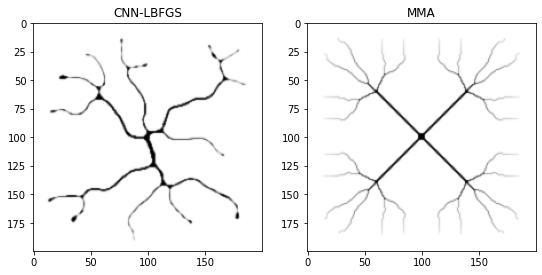

In [ ]:
all_plot(ds_cnn, ds_mma,0)

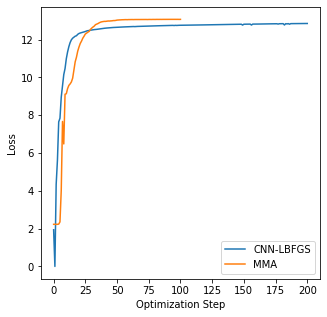

In [ ]:
all_plot2(ds_cnn, ds_mma,"pr3loss.eps")

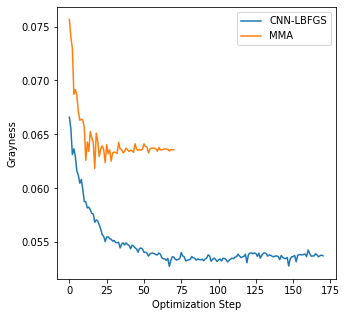

In [ ]:
all_plot3(ds_cnn, ds_mma,"pr3gray.eps", 30)

In [ ]:
envv = Environment(args)

In [ ]:
-envv.objective2(ds_cnn.design[-1].values)/2.25 *1000

12.668616586481125

In [ ]:
-envv.objective2(ds_mma.design[-1].values)/2.25 *1000

12.814898132167793

In [ ]:
cnn_aux1 = anp.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_cnn.design[-1][i][j] > 0.02:
      cnn_aux1[i][j] = 1

In [ ]:
mma_aux1 = anp.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_mma.design[-1][i][j] > 0.02:
      mma_aux1[i][j] = 1

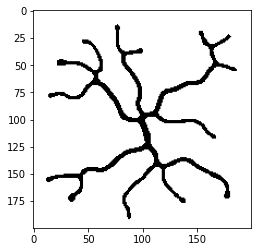

In [ ]:
plt.imshow(cnn_aux1, cmap='Greys')
plt.show()

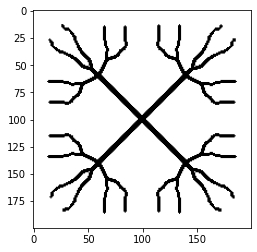

In [ ]:
plt.imshow(mma_aux1, cmap='Greys')
plt.show()

In [ ]:
-envv.objective2(cnn_aux1)/2.25 * 1000

12.255646561266506

In [ ]:
-envv.objective2(mma_aux1)/2.25 * 1000

11.987886384187112

In [ ]:
ds_cnn.design[-1].mean()  , ds_mma.design[-1].mean()

(<xarray.DataArray 'design' ()>
 array(0.0359192)
 Coordinates:
     step     int64 200, <xarray.DataArray 'design' ()>
 array(0.03144575)
 Coordinates:
     step     int64 100)

In [ ]:
cnn_aux2 = anp.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_cnn.design[-1][i][j] > 0.0359192:
      cnn_aux2[i][j] = 1

In [ ]:
mma_aux2 = anp.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_mma.design[-1][i][j] > 0.03144575:
      mma_aux2[i][j] = 1

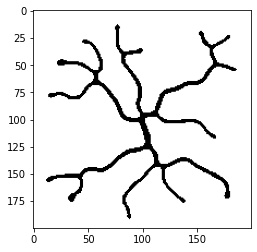

In [ ]:
plt.imshow(cnn_aux2, cmap='Greys')
plt.show()

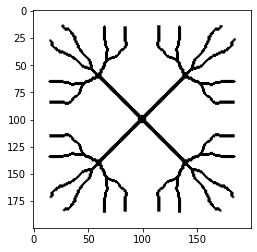

In [ ]:
plt.imshow(mma_aux2, cmap='Greys')
plt.show()

In [ ]:
-envv.objective2(cnn_aux2)/2.25 * 1000

12.366059717573023

In [ ]:
-envv.objective2(mma_aux2)/2.25 * 1000

12.22449696177521

#### Prob 4

In [ ]:
pr = Problem4(200,200,density = 0.06)
args = specified_task(pr)

In [ ]:
envv = Environment(args)

In [ ]:
cnn = CNNModel(args=args)
mma = PixelModel(args=args)

In [ ]:
ds_mma = method_of_moving_asymptotes(mma, 110)

LOSS  -0.00824034079813374   Eff  3.66237368805944
LOSS  -0.008241129303025755   Eff  3.6627241346781134
LOSS  -0.00824910006410434   Eff  3.6662666951574847
LOSS  -0.00836265299170189   Eff  3.716734662978618
LOSS  -0.009483708252655227   Eff  4.214981445624545
LOSS  -0.012730281584430514   Eff  5.657902926413562
LOSS  -0.01418175236520737   Eff  6.3030010512032755
LOSS  -0.01677944297571229   Eff  7.4575302114276845
LOSS  -0.01797405971296766   Eff  7.988470983541183
LOSS  -0.018773947668893082   Eff  8.343976741730259
LOSS  -0.019030012693030045   Eff  8.457783419124464
LOSS  -0.019769382291980265   Eff  8.786392129769007
LOSS  -0.020285243505847646   Eff  9.015663780376732
LOSS  -0.020776901567606924   Eff  9.234178474491966
LOSS  -0.02127018732338256   Eff  9.453416588170025
LOSS  -0.021763909309260445   Eff  9.67284858189353
LOSS  -0.02222817422948856   Eff  9.879188546439359
LOSS  -0.022659722184578016   Eff  10.070987637590228
LOSS  -0.023042970008146386   Eff  10.2413200036206

In [ ]:
ds_cnn = train_lbfgs(cnn,200)

Loss tf.Tensor(-0.004364061129198675, shape=(), dtype=float64)   Eff tf.Tensor(1.9395827240883, shape=(), dtype=float64)
Loss tf.Tensor(-0.00985064570419751, shape=(), dtype=float64)   Eff tf.Tensor(4.378064757421115, shape=(), dtype=float64)
Loss tf.Tensor(0.0012719451885008577, shape=(), dtype=float64)   Eff tf.Tensor(-0.5653089726670478, shape=(), dtype=float64)
Loss tf.Tensor(-0.015289625328495782, shape=(), dtype=float64)   Eff tf.Tensor(6.795389034887014, shape=(), dtype=float64)
Loss tf.Tensor(0.0021519353573316974, shape=(), dtype=float64)   Eff tf.Tensor(-0.9564157143696432, shape=(), dtype=float64)
Loss tf.Tensor(-0.016644582478536694, shape=(), dtype=float64)   Eff tf.Tensor(7.397592212682975, shape=(), dtype=float64)
Loss tf.Tensor(-0.017642747534014274, shape=(), dtype=float64)   Eff tf.Tensor(7.841221126228566, shape=(), dtype=float64)
Loss tf.Tensor(-0.01876606564894809, shape=(), dtype=float64)   Eff tf.Tensor(8.340473621754708, shape=(), dtype=float64)
Loss tf.Tensor(-

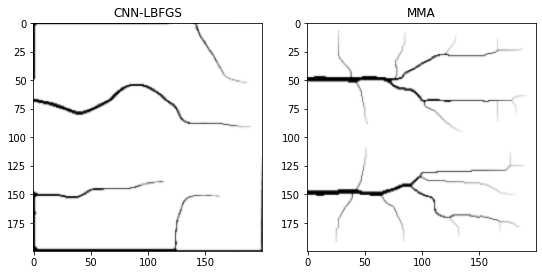

In [ ]:
all_plot(ds_cnn , ds_mma, 0)

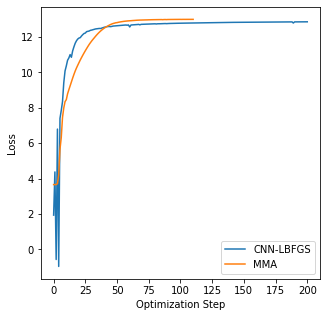

In [ ]:
all_plot2(ds_cnn, ds_mma, "sd")

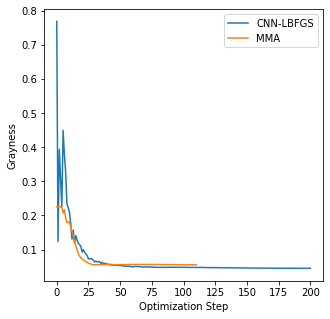

In [ ]:
all_plot3(ds_cnn, ds_mma, "sd")

In [ ]:
-envv.objective2(ds_cnn.design[-1].values) / 2.25 * 1000

12.849441524836395

In [ ]:
-envv.objective2(ds_mma.design[-1].values) / 2.25 * 1000

12.988146567448753

In [ ]:
cnn_aux1 = anp.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_cnn.design[-1][i][j] >= 0.02:
      cnn_aux1[i][j] = 1

In [ ]:
mma_aux1 = anp.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_mma.design[-1][i][j] >= 0.02:
      mma_aux1[i][j] = 1

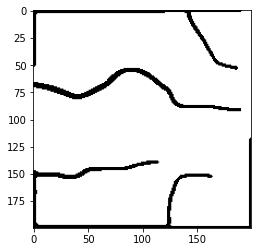

In [ ]:
plt.imshow(cnn_aux1, cmap='Greys')

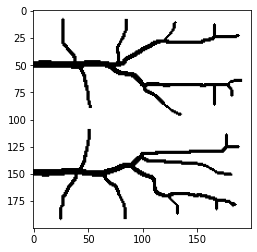

In [ ]:
plt.imshow(mma_aux1, cmap='Greys')

In [ ]:
-envv.objective2(cnn_aux1) / 2.25 *1000

12.64159455632543

In [ ]:
-envv.objective2(mma_aux1) / 2.25 *1000

12.556342072179518

In [ ]:
ds_cnn.design[-1].mean() , ds_mma.design[-1].mean()

(<xarray.DataArray 'design' ()>
 array(0.04110714)
 Coordinates:
     step     int64 200, <xarray.DataArray 'design' ()>
 array(0.03777428)
 Coordinates:
     step     int64 110)

In [ ]:
cnn_aux2 = anp.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_cnn.design[-1][i][j] >= 0.04110714:
      cnn_aux2[i][j] = 1

In [ ]:
mma_aux2 = anp.zeros((200,200))
for i in range(200):
  for j in range(200):
    if ds_mma.design[-1][i][j] >= 0.03777428:
      mma_aux2[i][j] = 1

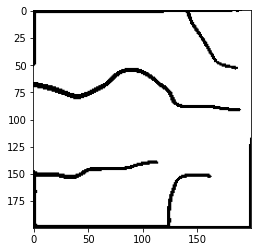

In [ ]:
plt.imshow(cnn_aux2, cmap='Greys')

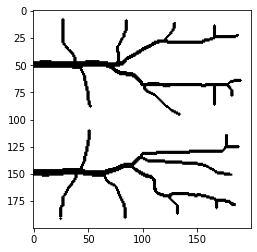

In [ ]:
plt.imshow(mma_aux2, cmap='Greys')

In [ ]:
-envv.objective2(cnn_aux2) / 2.25 *1000

12.703907407625174

In [ ]:
-envv.objective2(mma_aux2) / 2.25 *1000

12.673636435413364

### Explicit Volume Fraction

Experimenting with volume fraction. What happens if we explicitly pass volume fraction to the CNN Model?

Note : For running the following cells , the volume constraint part has to be uncommented  in sigmoid_with_constrained_mean function!

#### Prob 1

In [ ]:
pr = Problem1(200,200,0.05)
args = specified_task(pr)


In [ ]:
mma = PixelModel(args=args)

In [ ]:
ds_mma = method_of_moving_asymptotes(mma, 110)

LOSS  -0.009622833869538707   Eff  4.276815053128314
LOSS  -0.009622944950021231   Eff  4.276864422231658
LOSS  -0.009624061305530309   Eff  4.277360580235693
LOSS  -0.009640114778400608   Eff  4.284495457066937
LOSS  -0.009871177081655781   Eff  4.387189814069236
LOSS  -0.012073783039809589   Eff  5.3661257954709285
LOSS  -0.013220378965552872   Eff  5.875723984690166
LOSS  -0.014151253010179894   Eff  6.289445782302176
LOSS  -0.014288175507338172   Eff  6.350300225483632
LOSS  -0.013990895286935427   Eff  6.218175683082412
LOSS  -0.014382681999422218   Eff  6.392303110854319
LOSS  -0.014364951926777118   Eff  6.3844230785676075
LOSS  -0.01441683175315654   Eff  6.407480779180685
LOSS  -0.014340234205194192   Eff  6.373437424530752
LOSS  -0.014475141235618607   Eff  6.433396104719381
LOSS  -0.014521370021974544   Eff  6.453942231988686
LOSS  -0.013874391162530409   Eff  6.166396072235737
LOSS  -0.01454904450564051   Eff  6.466242002506893
LOSS  -0.01460338888362654   Eff  6.4903950593

In [ ]:
pr = Problem1(200,200,0.03865)
args = specified_task(pr)

In [ ]:
cnn =CNNModel(args=args)

In [ ]:
ds_cnn = train_lbfgs(cnn, 110)

Loss tf.Tensor(-0.00943419018733167, shape=(), dtype=float64)   Eff tf.Tensor(4.192973416591853, shape=(), dtype=float64)
Loss tf.Tensor(-0.01213682153504941, shape=(), dtype=float64)   Eff tf.Tensor(5.394142904466404, shape=(), dtype=float64)
Loss tf.Tensor(-0.014048979888403697, shape=(), dtype=float64)   Eff tf.Tensor(6.243991061512754, shape=(), dtype=float64)
Loss tf.Tensor(-0.016078789448494966, shape=(), dtype=float64)   Eff tf.Tensor(7.1461286437755405, shape=(), dtype=float64)
Loss tf.Tensor(-0.016761078807245658, shape=(), dtype=float64)   Eff tf.Tensor(7.449368358775848, shape=(), dtype=float64)
Loss tf.Tensor(-0.018458035591279544, shape=(), dtype=float64)   Eff tf.Tensor(8.20357137390202, shape=(), dtype=float64)
Loss tf.Tensor(-0.018788965480531102, shape=(), dtype=float64)   Eff tf.Tensor(8.35065132468049, shape=(), dtype=float64)
Loss tf.Tensor(-0.020282054265326727, shape=(), dtype=float64)   Eff tf.Tensor(9.014246340145212, shape=(), dtype=float64)
Loss tf.Tensor(-0.0

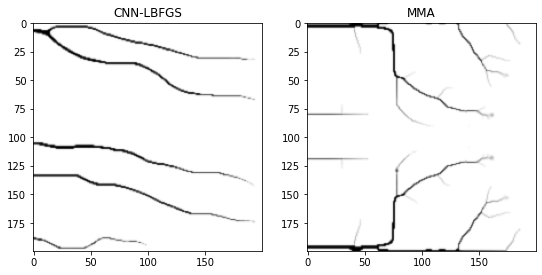

In [ ]:
all_plot(ds_cnn, ds_mma)

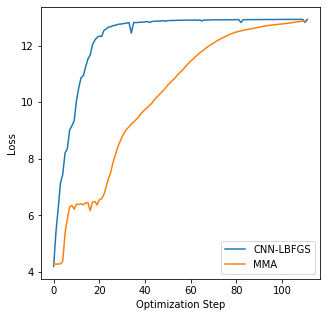

In [ ]:
all_plot2(ds_cnn, ds_mma, "Prob1_1.5_1.5_200.eps")

#### Prob 2

In [ ]:
pr = Problem2(200,200,density = 0.052)
args = specified_task(pr)

In [ ]:
mma2 = PixelModel(args=args)

In [ ]:
ds_mma2 = method_of_moving_asymptotes(mma2 ,100)

LOSS  14.408201781224694   Eff  -6403.645236099864
LOSS  12.889432741605855   Eff  -5728.636774047047
LOSS  10.629534596907444   Eff  -4724.237598625531
LOSS  8.30970452870484   Eff  -3693.2020127577066
LOSS  6.234486925943228   Eff  -2770.88307819699
LOSS  4.532899199261042   Eff  -2014.6218663382408
LOSS  3.2428320497460033   Eff  -1441.2586887760015
LOSS  0.7997869311114851   Eff  -355.46085827177114
LOSS  0.5478721600419237   Eff  -243.49873779641055
LOSS  0.017826257787721216   Eff  -7.922781238987207
LOSS  0.016131993983587552   Eff  -7.16977510381669
LOSS  0.0024267444313631308   Eff  -1.0785530806058359
LOSS  -0.004121641179905892   Eff  1.8318405244026188
LOSS  -0.004124982862430774   Eff  1.8333257166358994
LOSS  -0.0041722995196314784   Eff  1.8543553420584347
LOSS  -0.004722468372643297   Eff  2.0988748322859094
LOSS  -0.007076194961837085   Eff  3.14497553859426
LOSS  -0.010821369949711257   Eff  4.809497755427225
LOSS  -0.012075170625531808   Eff  5.366742500236359
LOSS  

In [ ]:
pr = Problem2(200,200,density = 0.04)
args = specified_task(pr)

In [ ]:
cnn2 = CNNModel(args=args)

In [ ]:
ds_cnn2 = train_lbfgs(cnn2, 100)

Loss tf.Tensor(38407.18003934586, shape=(), dtype=float64)   Eff tf.Tensor(-17069857.795264825, shape=(), dtype=float64)
Loss tf.Tensor(-0.008369869293539589, shape=(), dtype=float64)   Eff tf.Tensor(3.719941908239817, shape=(), dtype=float64)
Loss tf.Tensor(-0.008369869733123517, shape=(), dtype=float64)   Eff tf.Tensor(3.7199421036104523, shape=(), dtype=float64)
Loss tf.Tensor(-0.008369871206025883, shape=(), dtype=float64)   Eff tf.Tensor(3.7199427582337257, shape=(), dtype=float64)
Loss tf.Tensor(-0.008369876273736322, shape=(), dtype=float64)   Eff tf.Tensor(3.7199450105494765, shape=(), dtype=float64)
Loss tf.Tensor(-0.008369899952581123, shape=(), dtype=float64)   Eff tf.Tensor(3.7199555344804995, shape=(), dtype=float64)
Loss tf.Tensor(-0.00836999232749458, shape=(), dtype=float64)   Eff tf.Tensor(3.719996589997591, shape=(), dtype=float64)
Loss tf.Tensor(-0.008370363143981633, shape=(), dtype=float64)   Eff tf.Tensor(3.72016139732517, shape=(), dtype=float64)
Loss tf.Tensor(-

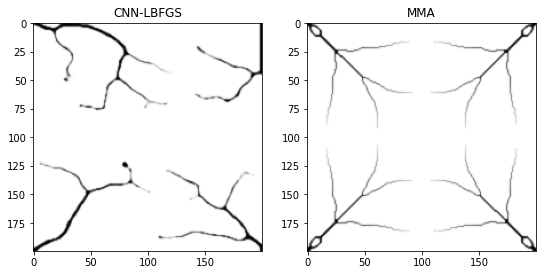

In [ ]:
all_plot(ds_cnn2, ds_mma2)

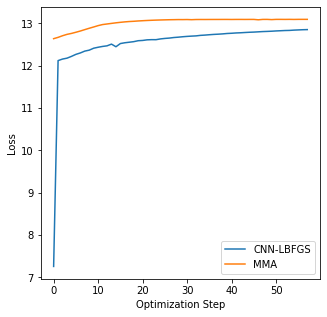

In [ ]:
all_plot2(ds_cnn2, ds_mma2, "Prob2_1.5_1.5_200.eps", 43)

#### Prob 3

In [ ]:
pr = Problem3(200,200,density = 0.052)
args = specified_task(pr)

In [ ]:
mma3 = PixelModel(args=args)

In [ ]:
ds_mma3 = method_of_moving_asymptotes(mma3, 80)

LOSS  14.408201781189232   Eff  -6403.645236084103
LOSS  12.779147003277902   Eff  -5679.620890345735
LOSS  10.384672470096936   Eff  -4615.409986709749
LOSS  7.968664821929919   Eff  -3541.628809746631
LOSS  5.852177332892101   Eff  -2600.9677035076006
LOSS  4.157248167729809   Eff  -1847.6658523243593
LOSS  2.9063644142763687   Eff  -1291.717517456164
LOSS  0.662744455398693   Eff  -294.553091288308
LOSS  0.4692601312387163   Eff  -208.56005832831838
LOSS  0.018634054745012146   Eff  -8.281802108894286
LOSS  0.016641950619461117   Eff  -7.396422497538274
LOSS  0.0016741208521367248   Eff  -0.7440537120607665
LOSS  -0.004112529510560281   Eff  1.8277908935823473
LOSS  -0.004115999452022191   Eff  1.8293330897876405
LOSS  -0.004165030647139007   Eff  1.851124732061781
LOSS  -0.004724358555298173   Eff  2.0997149134658546
LOSS  -0.007073664767418746   Eff  3.143851007741665
LOSS  -0.010829097140227324   Eff  4.812932062323255
LOSS  -0.012094933147428407   Eff  5.3755258433015145
LOSS  -

In [ ]:
pr = Problem3(200,200,density = 0.052)
args = specified_task(pr)

In [ ]:
cnn3 = CNNModel(args=args)

In [ ]:
ds_cnn3 = train_lbfgs(cnn3, 100)

Loss tf.Tensor(598639.5332613314, shape=(), dtype=float64)   Eff tf.Tensor(-266062014.78281397, shape=(), dtype=float64)
Loss tf.Tensor(-0.011063591181700142, shape=(), dtype=float64)   Eff tf.Tensor(4.917151636311175, shape=(), dtype=float64)
Loss tf.Tensor(-0.011063593972463159, shape=(), dtype=float64)   Eff tf.Tensor(4.9171528766502925, shape=(), dtype=float64)
Loss tf.Tensor(-0.011063595506346705, shape=(), dtype=float64)   Eff tf.Tensor(4.917153558376314, shape=(), dtype=float64)
Loss tf.Tensor(-0.011063604261264282, shape=(), dtype=float64)   Eff tf.Tensor(4.917157449450792, shape=(), dtype=float64)
Loss tf.Tensor(-0.011063642124881, shape=(), dtype=float64)   Eff tf.Tensor(4.917174277724889, shape=(), dtype=float64)
Loss tf.Tensor(-0.011063773934149283, shape=(), dtype=float64)   Eff tf.Tensor(4.917232859621904, shape=(), dtype=float64)
Loss tf.Tensor(-0.011064330497414674, shape=(), dtype=float64)   Eff tf.Tensor(4.9174802210731885, shape=(), dtype=float64)
Loss tf.Tensor(-0.0

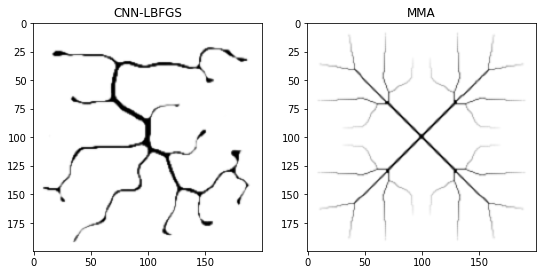

In [ ]:
all_plot(ds_cnn3, ds_mma3)

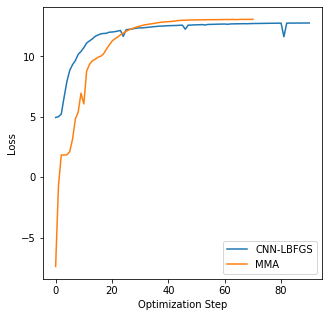

In [ ]:
all_plot2(ds_cnn3, ds_mma3, "Prob3_1.5_1.5_200.eps", 10)

### Notes

1. From these experiments, it can be observed that the exact designs provided by CNN may have lower efficiency compared to the exact designs of MMA. But, MMA designs tend to have more Grayness than their CNN counterparts. So, applying a threshold filter to the designs reveal the robustness and competitiveness of the CNN designs as they have higher effifiency values post-processing.

2. Forcing a volume constraint (equality or inequality) to the CNN can hamper the optimization process. If a volume constraint is explicityly passed, CNN gets restricted to a very little domain of designs. This can either improve or worsen its performance. Moreover, Solar Cell Metallization problem is not (and should not be) constrained by volume fraction.

3. MMA , by application, is a symmetric optimization algorithm. It always searches for  symmetric optimal values. Contrary to that, CNN is open to explore the sphere of non-symmetric values which , contrary to or supportive of intuition, may result in imrpoved performance. In the MMA designs obtained above, symmetry is noticeable. But along with that, minor local areas of asymmetry can also be detected. This asymmetry arises out of the fact that in the calculation of U, _Newton Raphson_ method is used. It outputs the best approximate value of U. Unlike Structural or Heat Flow optimization, where exact value of U is calculated owing to the linear natue of the problems, Solar Cell Design optimization is non-linear. This advocates for the fact that not always an exact value of U can be obtained here, and this clearly explains the appearance of minor asymmetric patterns in the MMA designs.





